In [1]:
import os
os.chdir("../")
os.environ["JAX_ENABLE_X64"] = "true"

import pickle
import matplotlib.pyplot as plt
import jax.numpy as np

/opt/homebrew/Caskroom/miniconda/base/envs/scipy-dev/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [85]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

def eval_densities(xgrid, lam, m, j, atoms):
    weights = lam @ (m * j)
    weights /= weights.sum(axis=1)[:, np.newaxis]
    vars = np.array(atoms[:, 1])
    #vars = vars.at[vars < 0.15].set(0.15)
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(vars)).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

In [ ]:
state

In [82]:
with open("invalsi/chains_mgp3.pickle", "rb") as fp:
    states = pickle.load(fp)
    
    
with open("invalsi/math_grades.pickle", "rb") as fp:
    data = pickle.load(fp)

In [83]:
nlat = states[-1].m.shape[0]

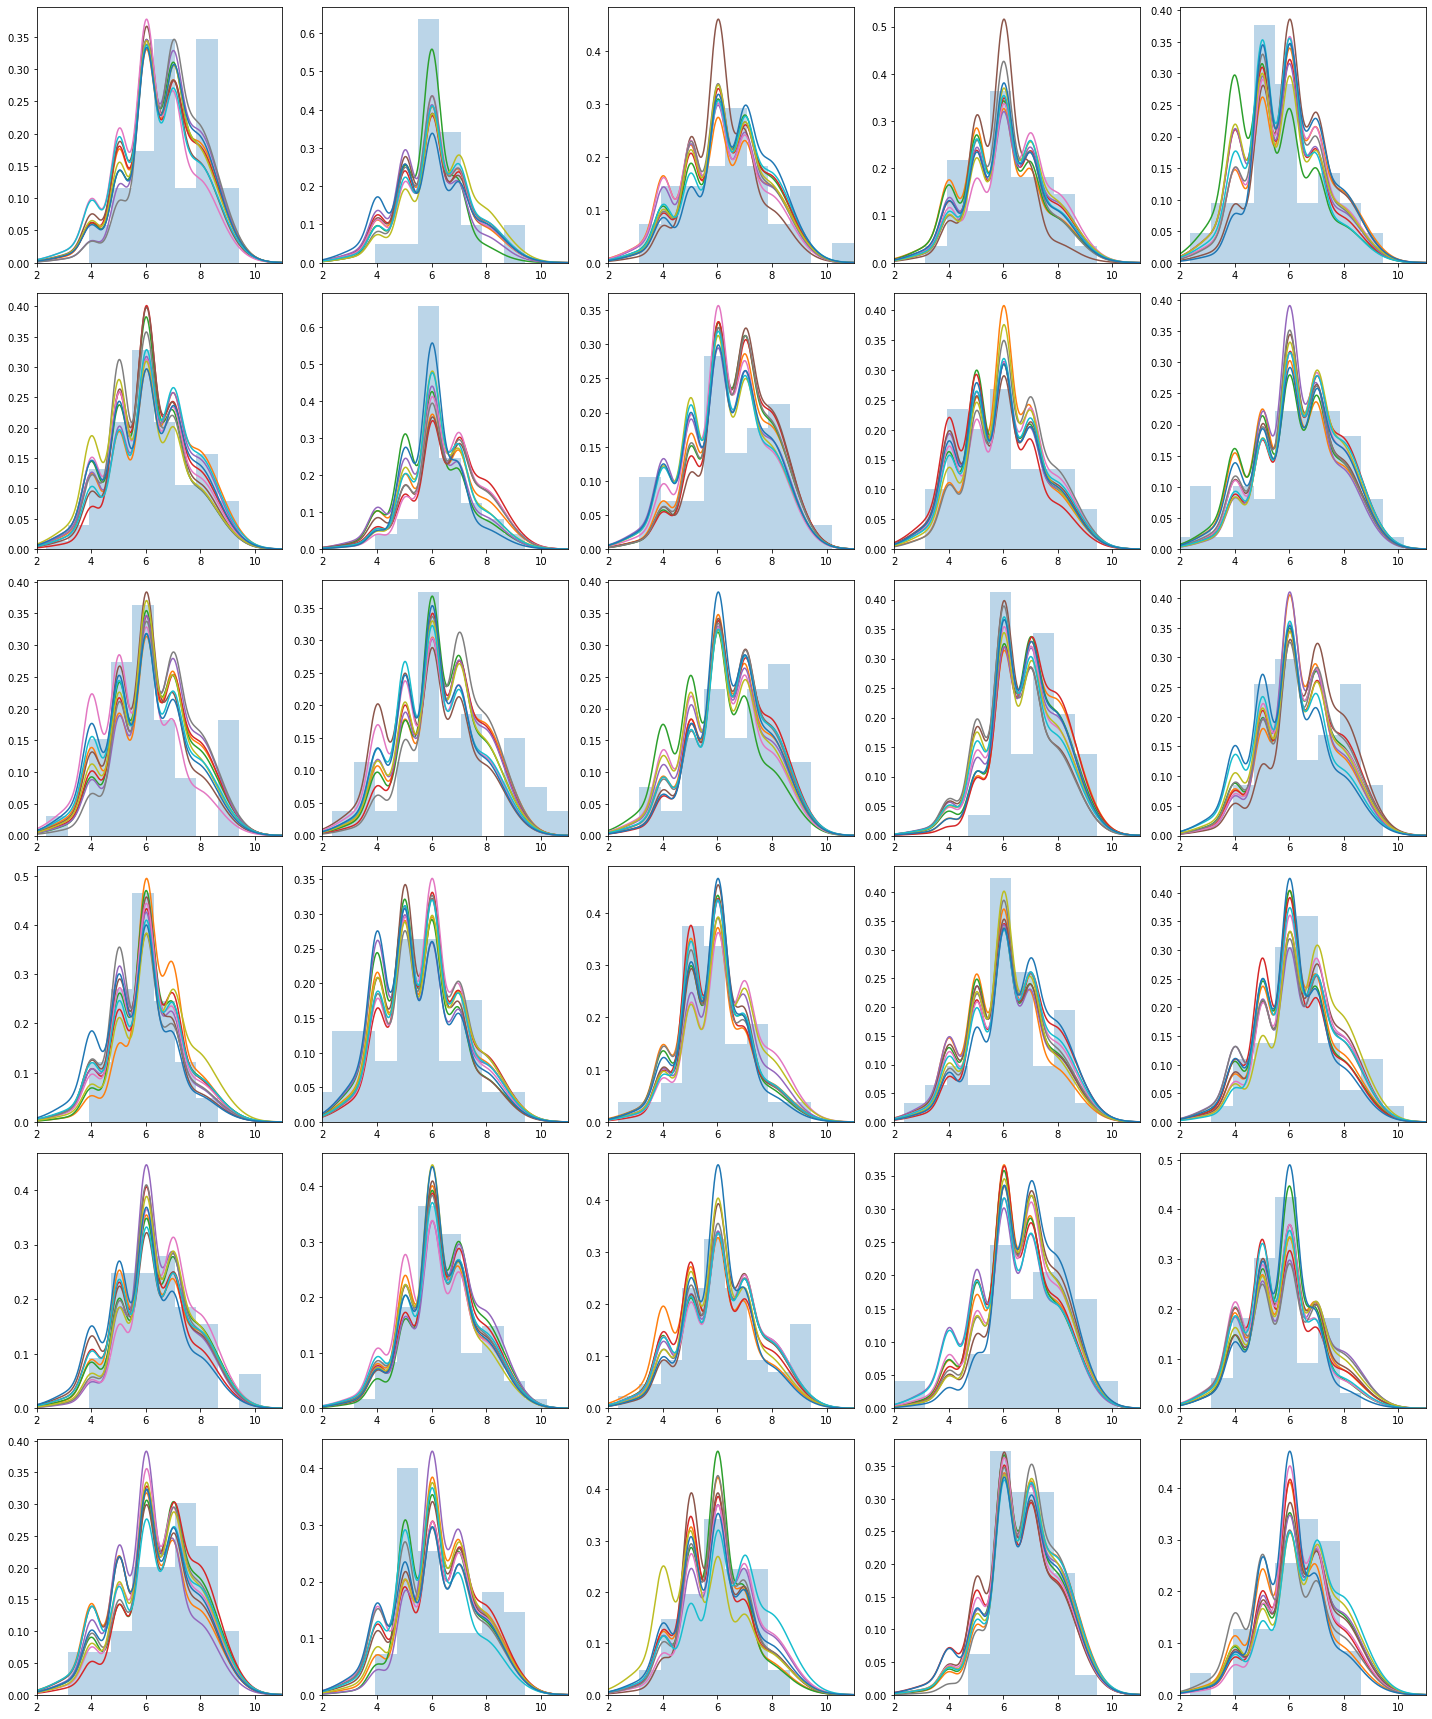

In [86]:
xgrid = np.linspace(2, 11, 1000)

toshow = list(range(30))
ncols = 5
nrows = int(len(toshow) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))
axes = axes.flat

idx = np.arange(1, len(states), 100)

for i in toshow:
    axes[i].hist(data[i, :], density=True, alpha=0.3, bins=np.linspace(0, 11, 15))

for j in sorted(idx):
    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in toshow:
        axes[i].plot(xgrid, dens[i, :], label="j: {0}".format(len(states) + j))
        axes[i].set_xlim(2, 11)
        
#axes[0].legend(fontsize=12)   
plt.tight_layout()
# plt.savefig("invalsi/dens_estimate.pdf", bbox_inches="tight")        
plt.show()

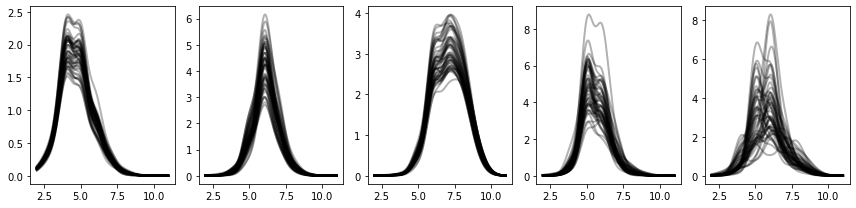

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(12, 3))

for j in np.arange(0, len(states), 20):
    state = states[j]
    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(vars)).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], color="black", lw=2, alpha=0.3)
        
#axes[0].legend(fontsize=12)

plt.tight_layout()

#plt.savefig("../latex/images/invalsi_latent_draws.pdf", bbox_inches="tight")        
plt.show()

In [88]:
avg_lat_dens = np.zeros((nlat, len(xgrid)))

for state in states[-500:]:
    vars = np.array(state.atoms[:, 1])
    vars = vars.at[vars < 0.15].set(0.15)
    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(vars)).prob(xgrid[:, np.newaxis])
    
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T  
    avg_lat_dens += dens_lat

avg_lat_dens /= len(states)

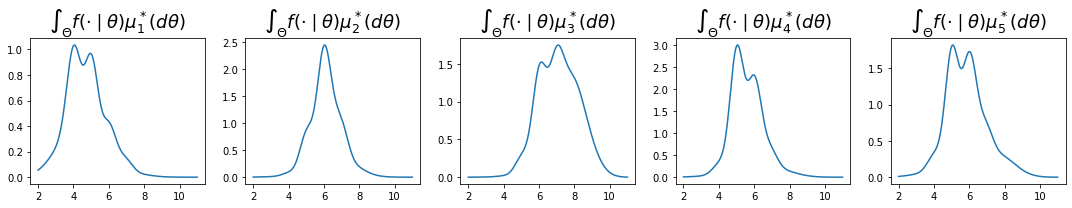

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))


for i in range(nlat):
    axes[i].plot(xgrid, avg_lat_dens[i, :], label="j: {0}".format(len(states) + j))
    axes[i].set_title(r"$\int_\Theta f(\cdot \mid \theta )\mu^*_{0}(d\theta)$".format(i+1), fontsize=18)
        
#axes[0].legend(fontsize=12)

plt.tight_layout()

# plt.savefig("invalsi/avg_latent_dens.pdf", bbox_inches="tight")        
plt.show()

In [90]:
import matplotlib.colors as colors
import numpy as onp

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return onp.ma.masked_array(onp.interp(value, x, y), onp.isnan(value))

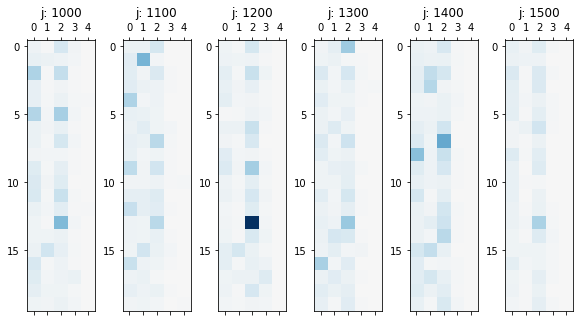

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))

idx = sorted(idx)

lambs = np.array([states[i].lam[:20, :] for i in idx])
vmax = np.max(lambs)

for i in range(len(idx))[:6]:
    lam = lambs[i]
    im = axes[i].matshow(lam, cmap="RdBu", 
                         clim=(-10, np.max(lambs)), 
                         norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=vmax))
    axes[i].set_title("j: {0}".format(len(states) + idx[i]))


#plt.savefig("invalsi/lambdas.pdf", bbox_inches="tight")

plt.show()

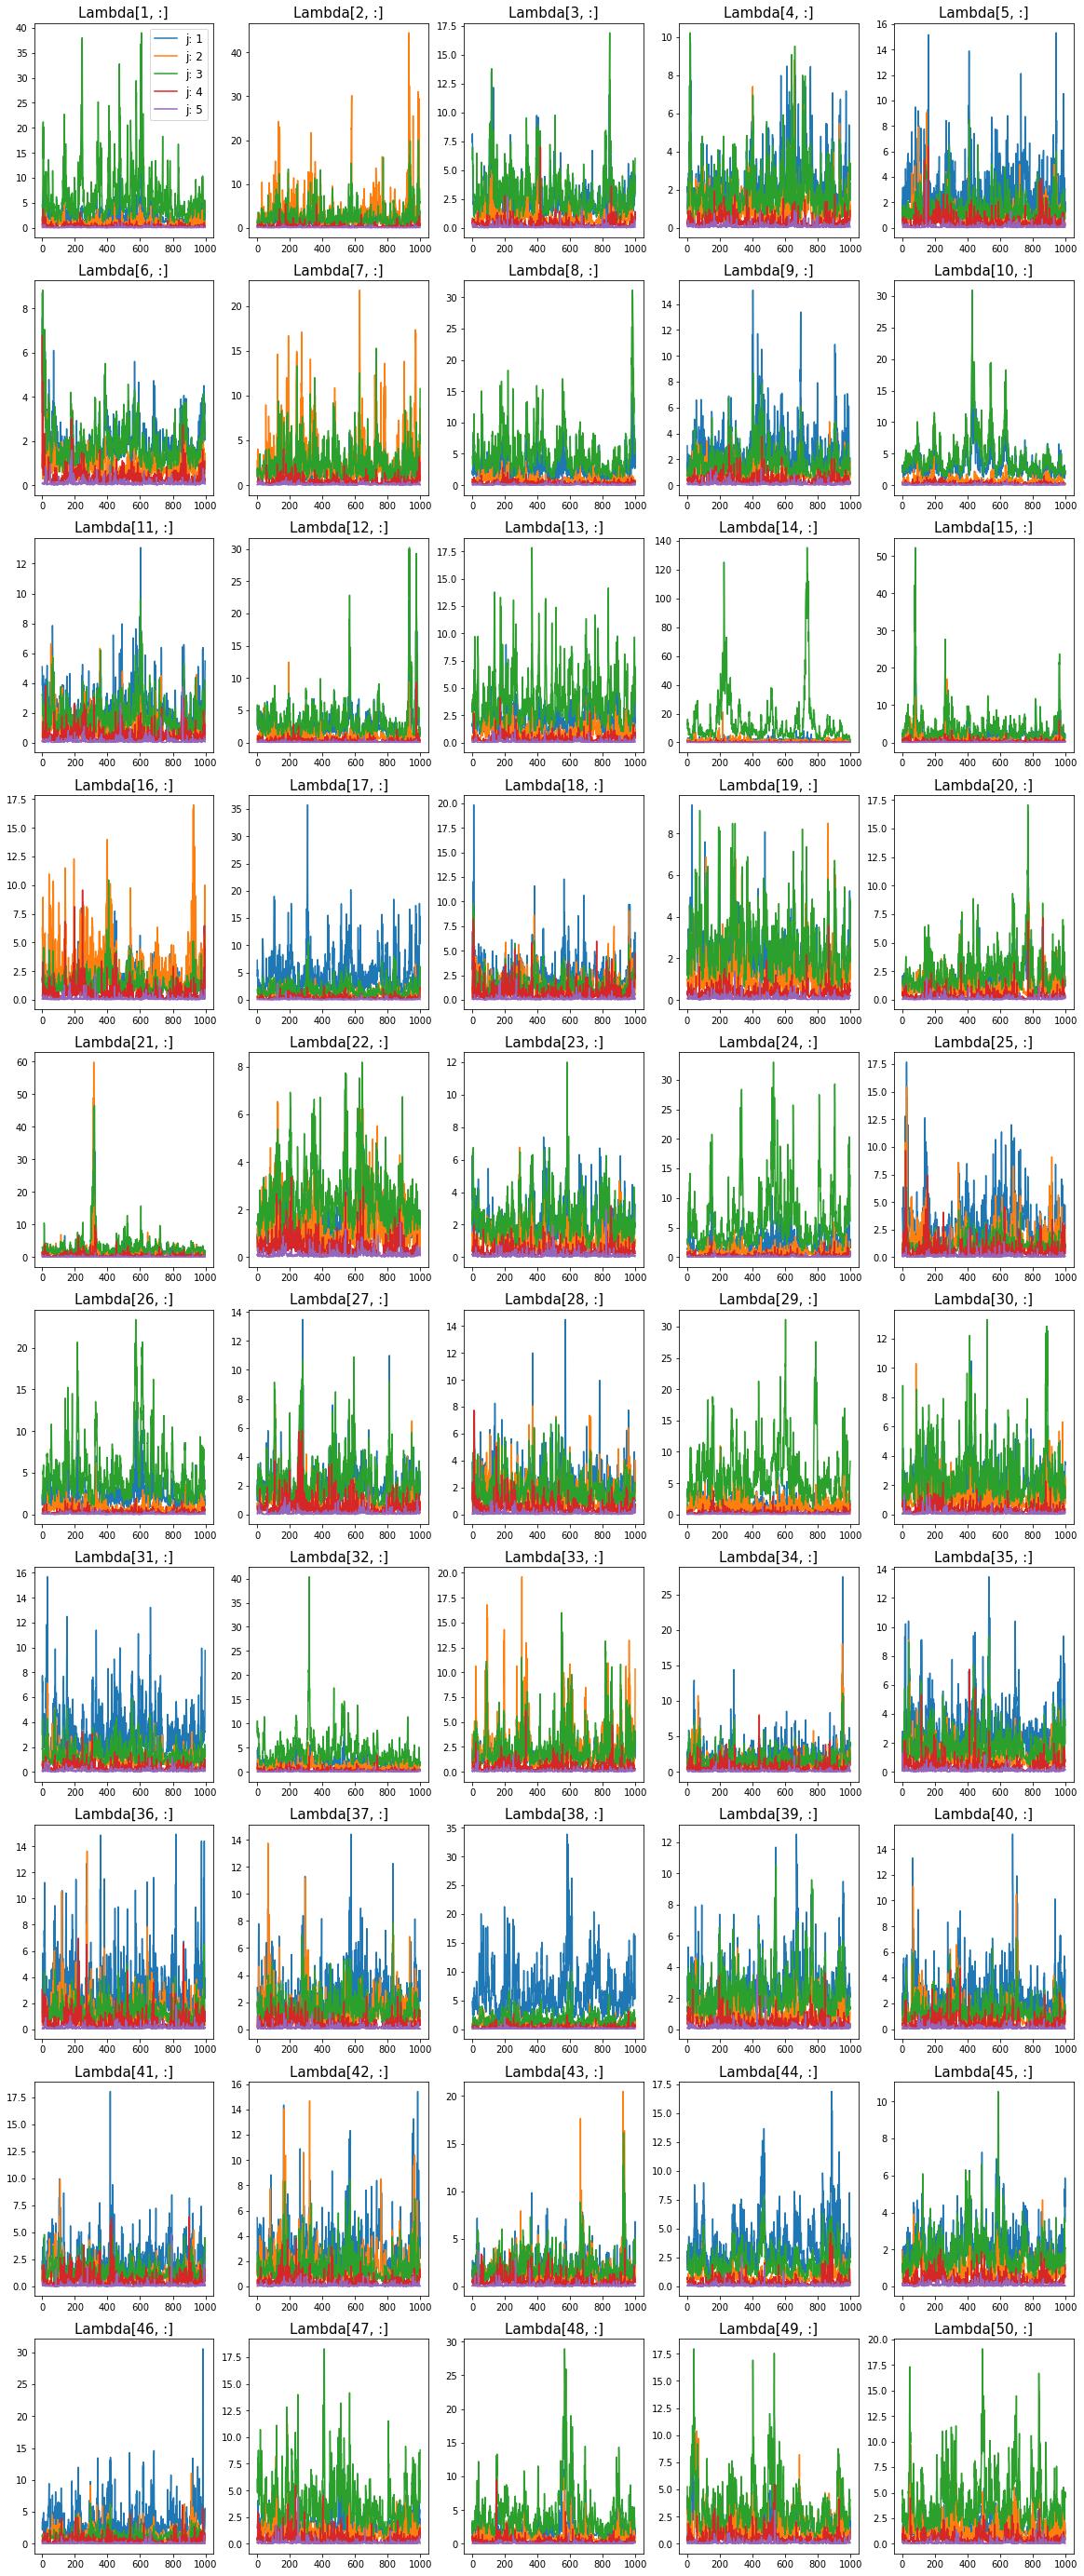

In [92]:
toshow = list(range(50))
ncols = 5
nrows = int(len(toshow) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flat

for i in toshow:
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

In [93]:
# Postprocess

def discretize_dens(dens, xgrid):
    delta = xgrid[1] - xgrid[0]
    out = np.zeros_like(xgrid)
    for j in np.arange(2, 11):
        wh = np.where((xgrid > j) & (xgrid < j+1))
        d = np.sum(dens[wh]) * delta
        out = out.at[wh].set(d)
    return out


M = states[-1].m
lam = states[-1].lam
J = states[-1].j


vars = np.array(states[-1].atoms[:, 1])
vars = vars.at[vars < 0.2].set(0.2)
component_dens = tfd.Normal(
    loc=states[-1].atoms[:, 0], scale=np.sqrt(vars)).prob(xgrid[:, np.newaxis]).T

#component_dens = np.array([
#    tfd.Normal(x[0], np.sqrt(x[1])).prob(xgrid) for x in states[-1].atoms])

#discretized_dens = np.stack([
#    discretize_dens(x, xgrid) for x in component_dens  
#])

delta = xgrid[1] - xgrid[0]


def obj_func(x):
    curr_m = x @ M
    trans_dens = (curr_m * J) @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = (np.sum((trans_dens[i, :] * trans_dens[j, :])) * delta)**2  
            out += curr
            # print("i: {0}, j: {1}, curr: {2}".format(i, j, curr))
    return out


def constraints(x):
    return - np.concatenate([
        (lam @ np.linalg.inv(x)).reshape(-1, 1),
        (x @ M).reshape(-1, 1)])[:, 0]

def max0(x):
    return x * (x > 0)

def penalty(x, lambdas):
    return 0.5 * 1.0 * np.sum(max0(lambdas / 0.5 + constraints(x))**2)

In [94]:
component_dens.shape

(10, 1000)

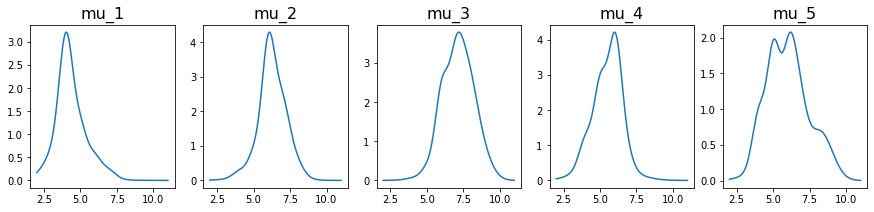

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
    
#plt.savefig("invalsi/avg_mu.pdf", bbox_inches="tight")

In [96]:
from jax import grad


grad_f = grad(obj_func)
f = obj_func

In [97]:
from nrmifactors.postprocess import dissipative_lie_rattle_fast

x0 = np.eye(M.shape[0])
opt_x, niter = dissipative_lie_rattle_fast(f, grad_f, x0, 0.9, 1e-5, 1e-6, maxiter=10000)
opt_x

DeviceArray([[ 9.69346293e-01, -7.12567707e-02,  7.04188433e-02,
              -1.78344922e-01, -7.24868390e-02],
             [ 6.21525642e-02,  1.02325666e+00,  7.32702035e-02,
               7.23046509e-03,  3.62196714e-02],
             [ 1.92059130e-02, -9.49838212e-02,  9.67771272e-01,
              -1.08269924e-01, -4.38355074e-02],
             [ 3.52898127e-02, -6.79324314e-04,  4.77123525e-02,
               1.03761126e+00,  2.93214993e-02],
             [ 2.56544637e-02, -4.74293867e-02,  4.68671022e-02,
              -5.62504905e-02,  9.76777227e-01]], dtype=float64)

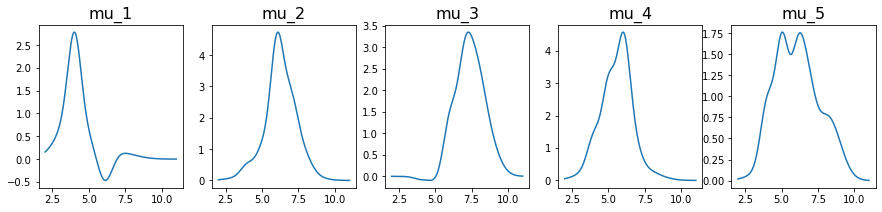

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (q @ M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
#plt.savefig("invalsi/opt_mu_unc.pdf", bbox_inches="tight")

In [102]:
from jax import jacfwd
from nrmifactors.postprocess import ralm

constr_eval = constraints(x0)
grad_cons = jacfwd(constraints)

mu = 0.1
stepsize = 1e-6
init_thr = 1e-2
target_thr = 1e-6
min_lambda = 1e-4
init_lambdas = np.zeros_like(constr_eval) + 0.1
max_lambda = 30
init_rho = 10
dmin = 1e-6


opt_x_pen = ralm(
    obj_func, grad_f, constraints, grad_cons, opt_x, mu, stepsize, 
    init_thr, target_thr, init_lambdas, min_lambda, max_lambda, 
    init_rho, dmin, maxiter=1000)

Init Loss:  0.26848587846563554
Loss: 0.34848495769552346, step: 50.19721676207737, eps: 0.01
max(lambdas) :  30.0
Loss: 0.34863090531474966, step: 0.12486685461510405, eps: 0.009000000000000001
max(lambdas) :  30.0
Loss: 0.3457665873840927, step: 0.024058765100982465, eps: 0.008100000000000001
max(lambdas) :  30.0
Loss: 0.34633793533601687, step: 0.012864821936660208, eps: 0.007290000000000001
max(lambdas) :  30.0
Loss: 0.347013530880947, step: 0.009281489825480455, eps: 0.006561000000000002
max(lambdas) :  30.0
Loss: 0.3475777511596736, step: 0.006909166406158876, eps: 0.005904900000000002
max(lambdas) :  30.0
Loss: 0.348014267652785, step: 0.005147992074067569, eps: 0.005314410000000002
max(lambdas) :  30.0
Loss: 0.34834510582311445, step: 0.003918110511298361, eps: 0.004782969000000002
max(lambdas) :  30.0
Loss: 0.3485923618149809, step: 0.0030798892851246146, eps: 0.004304672100000002
max(lambdas) :  30.0
Loss: 0.3487860480122333, step: 0.0024886996054042285, eps: 0.00387420489000

Loss: 0.35199764780219495, step: 0.0006846022696727741, eps: 1.5926791088519833e-06
max(lambdas) :  30.0
Loss: 0.35203017003970255, step: 0.0006836940174116866, eps: 1.433411197966785e-06
max(lambdas) :  30.0
Loss: 0.35206255881265297, step: 0.0006827906617918099, eps: 1.2900700781701065e-06
max(lambdas) :  30.0
Loss: 0.3520948151685583, step: 0.0006818921478401825, eps: 1.161063070353096e-06
max(lambdas) :  30.0
Loss: 0.35212694014065715, step: 0.0006809984203509561, eps: 1.0449567633177863e-06
max(lambdas) :  30.0
Loss: 0.35215893474804144, step: 0.0006801094241344592, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35219079999580905, step: 0.0006792251042050579, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3522225368752322, step: 0.0006783454058663688, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35225414636395, step: 0.0006774702748012062, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3522856294261654, step: 0.0006765996571952759, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35231698701286096, step: 0.00067573

Loss: 0.354693947729017, step: 0.0006118789031960377, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3547167837266978, step: 0.0006112737876569396, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35473954748235315, step: 0.0006106706011458083, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3547622393649228, step: 0.0006100693302606373, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.354784859740539, step: 0.0006094699617700873, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35480740897256585, step: 0.0006088724825364784, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35482988742162974, step: 0.000608276879626545, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35485229544565405, step: 0.0006076831402425106, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3548746333998923, step: 0.0006070912517109456, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35489690163696114, step: 0.0006065012014838248, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3549191005068702, step: 0.0006059129772513702, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35494123035705455, step: 0.000605

max(lambdas) :  30.0
Loss: 0.35660183883869395, step: 0.0005610624216885676, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35661910746944137, step: 0.000560597274503939, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35663632995385575, step: 0.0005601332286404777, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3566535064908266, step: 0.0005596702786662665, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3566706372781227, step: 0.0005592084191495901, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3566877225124039, step: 0.0005587476446929147, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35670476238922566, step: 0.0005582879499405947, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35672175710304965, step: 0.0005578293296094164, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3567387068472505, step: 0.0005573717784472703, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35675561181412474, step: 0.0005569152911741993, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3567724721948971, step: 0.0005564598626365765, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.356789288

Loss: 0.35812858329628, step: 0.0005192506256449375, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35814206781735003, step: 0.0005188738910098102, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.358155521606881, step: 0.0005184978631665977, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3581689447822558, step: 0.0005181225393038466, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3581823374602736, step: 0.0005177479166383678, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3581956997571542, step: 0.0005173739923578813, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35820903178853974, step: 0.0005170007637653474, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35822233366949885, step: 0.0005166282281044268, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.358235605514531, step: 0.000516256382645609, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35824884743756824, step: 0.0005158852246768423, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35826205955197954, step: 0.0005155147515178337, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3582752419705737, step: 0.000515144

Loss: 0.3592759264242666, step: 0.0004865953354601428, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3592869663405791, step: 0.00048627466391915796, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35929798440557836, step: 0.0004859544936962635, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35930898069412087, step: 0.00048563482305921245, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593199552807208, step: 0.0004853156503287414, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593309082395506, step: 0.00048499697387242987, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593418396444434, step: 0.0004846787920487185, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.359352749568895, step: 0.00048436110313313446, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.35936363808606525, step: 0.0004840439055286077, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593745052687803, step: 0.00048372719761069613, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593853511895341, step: 0.0004834109777571588, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3593961759204911, step: 0.00

Loss: 0.3602642407113643, step: 0.0004573229901129567, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36027344885030227, step: 0.00045704454409620747, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36028264109048486, step: 0.0004567664671730854, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3602918174805255, step: 0.0004564887583005208, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36030097806883316, step: 0.00045621141643965347, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36031012290361303, step: 0.0004559344405526147, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3603192520328686, step: 0.0004556578295190473, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3603283655044015, step: 0.00045538158232327373, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3603374633658144, step: 0.00045510569791847385, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3603465456645078, step: 0.0004548301753017796, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3603556124476876, step: 0.00045455501338055923, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36036466376236004, step: 0

Loss: 0.361105645541798, step: 0.00043139583649365337, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611134870051959, step: 0.00043114939755073737, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36112131653456314, step: 0.0004309032410862993, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611291341625247, step: 0.00043065736642810805, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611369399215813, step: 0.0004304117728201555, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611447338441088, step: 0.0004301664595659608, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611525159623586, step: 0.00042992142596748117, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36116028630845937, step: 0.00042967667138250974, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611680449144169, step: 0.0004294321950459717, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611757918121148, step: 0.00042918799628187935, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3611835270333151, step: 0.0004289440744003535, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36119125060965884, step: 0.0

Loss: 0.3618219341178015, step: 0.00040848871242925484, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36182874403935184, step: 0.00040826696186683164, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36183554470970275, step: 0.0004080454356336739, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3618423361516211, step: 0.0004078241332587173, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.361849118387795, step: 0.0004076030541761345, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36185589144083197, step: 0.00040738219795291765, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.361862655333262, step: 0.0004071615640991961, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36186941008753526, step: 0.0004069411521402952, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36187615572602505, step: 0.0004067209615643969, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3618828922710252, step: 0.00040650099190493884, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36188961974475403, step: 0.00040628124268418295, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3618963381693509, step: 0.

Loss: 0.362460526584738, step: 0.0003873509401138489, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36246651246423023, step: 0.00038714944602565146, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3624724910255908, step: 0.00038694813471290036, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36247846228510705, step: 0.0003867470058155237, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3624844262590152, step: 0.0003865460589871419, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36249038296349817, step: 0.00038634529393224466, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3624963324146878, step: 0.0003861447102827572, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3625022746286653, step: 0.0003859443076623093, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3625082096214599, step: 0.0003857440857520726, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36251413740905014, step: 0.0003855440442053208, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36252005800736326, step: 0.0003853441827185244, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36252597143227633, step: 0.0

Loss: 0.3630146622457365, step: 0.000368424202302937, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36302000114315497, step: 0.0003682391260072798, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36302533409990423, step: 0.00036805420321733704, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3630306611280339, step: 0.00036786943369760777, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3630359822395586, step: 0.0003676848171441086, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36304129744645625, step: 0.00036750035333621997, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3630466067606709, step: 0.00036731604200266916, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.3630519101941104, step: 0.00036713188291087075, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36305720775864736, step: 0.0003669478758391283, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36306249946612074, step: 0.0003667640204599172, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36306778532833406, step: 0.0003665803165762214, eps: 1e-06
max(lambdas) :  30.0
Loss: 0.36307306535705586, step: 

In [103]:
opt_x_pen

DeviceArray([[ 1.40226676,  0.01252834,  0.02244206, -0.05939162,
              -0.01804558],
             [ 0.07109753,  0.55422305,  0.04822937,  0.01878218,
               0.00428698],
             [ 0.06664519,  0.04018055,  1.80194101, -0.03222346,
               0.03923921],
             [ 0.06857239,  0.03063237,  0.08801846,  0.74553575,
               0.00499971],
             [ 0.04020267, -0.0213161 ,  0.11432902, -0.04160904,
               0.95883645]], dtype=float64)

In [147]:
from scipy.integrate import trapz


def discretize_dens(dens, xgrid):
    out = []
    wh = np.where(xgrid < 1.5)
    out.append(trapz(dens[wh], xgrid[wh]))
    for i in range(2, 10):
        wh = np.where((xgrid >= i - 0.5) & (xgrid < i + 0.5))
        out.append(trapz(dens[wh], xgrid[wh]))
    
    wh = np.where(xgrid > 9.5)
    out.append(trapz(dens[wh], xgrid[wh]))
    return out

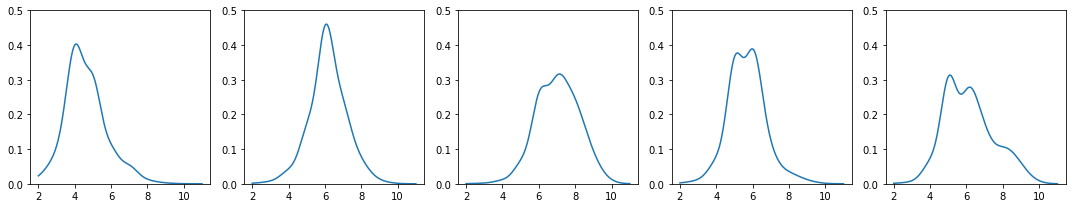

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x_pen

for j in range(M.shape[0]):
    d = (q @ (M * J) @ component_dens )[j, :]
    d = d / np.sum(d * (xgrid[1] - xgrid[0]))
    axes[j].plot(xgrid,  d)
    axes[j].set_ylim((0.0, 0.5))

plt.tight_layout()

#plt.savefig("../latex/images/invalsi_latent_factors.pdf", bbox_inches="tight")
plt.show()

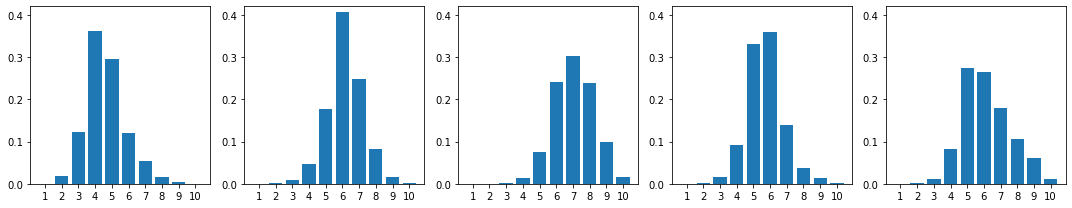

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x_pen

for j in range(M.shape[0]):
    d = (q @ (M * J) @ component_dens )[j, :]
    d = d / np.sum(d * (xgrid[1] - xgrid[0]))
    bars = np.arange(1, 11)
    heights = discretize_dens(d, xgrid)
    axes[j].bar(bars,  heights)
    axes[j].set_xticks(bars)
    axes[j].set_ylim((0.0, 0.42))

plt.tight_layout()
#plt.savefig("../latex/images/invalsi_latent_factors_discrete.pdf", bbox_inches="tight")
plt.show()

In [105]:
post_lam = lam @ np.linalg.inv(opt_x_pen)

In [106]:
masses = np.sum(q @ M @ component_dens * delta, axis=1)

In [107]:
lambda_trans = post_lam * masses
lambda_trans /= np.sum(lambda_trans, axis=1,keepdims=True)

In [108]:
np.sum(lambda_trans, axis=0)

DeviceArray([331.07137149, 184.04565134, 351.13066122, 165.6814379 ,
              16.07087806], dtype=float64)

# cluster based on the factor scores

In [109]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as onp


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = onp.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [110]:
model = AgglomerativeClustering(linkage="complete", distance_threshold=0, n_clusters=None)

X = onp.array(lambda_trans)
model.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

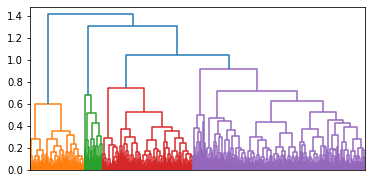

In [127]:
fig = plt.figure(figsize=(6, 3))

#plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level")
plt.xticks([])
#plt.savefig("../latex/images/invalsi_hclust_complete.pdf", bbox_inches="tight")
plt.show()

In [115]:
from scipy import cluster

X = onp.array(lambda_trans)
Z = cluster.hierarchy.complete(X)
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=4)[:, 0]

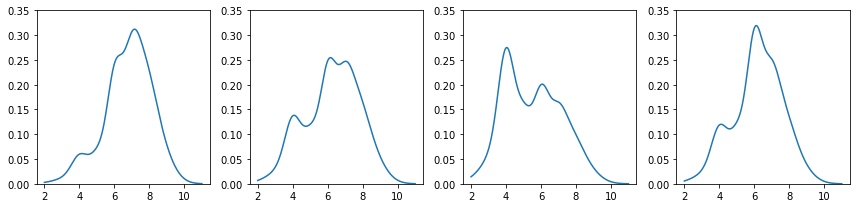

In [140]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes = axes.flat

latent_dens = q @ M @ component_dens

for l in onp.array(np.unique(cutree)):
    idxs = np.where(cutree == l)[0]
    avg_lam = np.mean(lambda_trans[idxs, :], axis=0)
    dens = avg_lam @ latent_dens
    dens /= np.sum(dens * delta)
    axes[l].plot(xgrid, dens)
    axes[l].set_ylim((0.0, 0.35))
    
plt.tight_layout()
#plt.savefig("../latex/images/invalsi_cluster_dens.pdf")

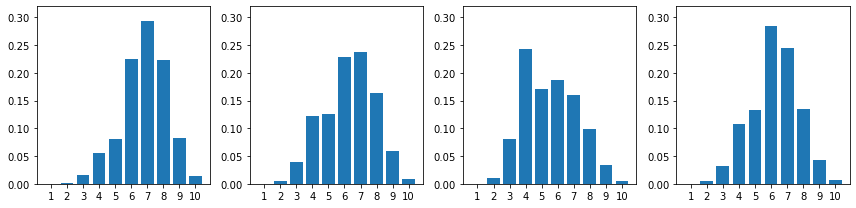

In [146]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes = axes.flat

latent_dens = q @ M @ component_dens

for l in onp.array(np.unique(cutree)):
    idxs = np.where(cutree == l)[0]
    avg_lam = np.mean(lambda_trans[idxs, :], axis=0)
    dens = avg_lam @ latent_dens
    dens /= np.sum(dens * delta)
    bars = np.arange(1, 11)
    heights = discretize_dens(dens, xgrid)
    axes[l].bar(bars,  heights)
    axes[l].set_xticks(bars)
    axes[l].set_ylim((0.0, 0.32))
    
plt.tight_layout()
#plt.savefig("../latex/images/invalsi_cluster_dens_discrete.pdf")